# Dijkstra Routing Test

This notebook tests Dijkstra algorithm routing performance with the current network configuration:
- **Network Size**: Tests with current number of operational nodes
- **Terminal Pairs**: Multiple source-destination pairs
- **Metrics**: Success rate, path length, latency, hops, resource awareness
- **Comparison**: Can compare with RL agent if available


## 1. Setup & Configuration


In [1]:
# Setup paths and imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
import time
import heapq
import math
warnings.filterwarnings('ignore')

# Add backend to path
backend_path = os.path.abspath('..')
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Setup complete")


✓ Setup complete


In [2]:
# Import project modules
from config import Config
from models.database import Database
from api.routing_bp import calculate_path_dijkstra, calculate_distance

# Initialize
config = Config.get_yaml_config()
db = Database()
db.connect()

print("✓ Modules loaded")
print(f"✓ Database connected: {db.db.name}")
print(f"✓ Config loaded")


✓ Modules loaded
✓ Database connected: aiprancs
✓ Config loaded


## 2. Load Network Data


In [3]:
# Load nodes and terminals from database
nodes_collection = db.get_collection('nodes')
terminals_collection = db.get_collection('terminals')

# Get operational nodes
nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}))
terminals = list(terminals_collection.find({}, {'_id': 0}))

# Count total nodes
total_nodes = nodes_collection.count_documents({})
operational_nodes = len(nodes)

print(f"📊 Network Statistics:")
print(f"  Total nodes in database: {total_nodes}")
print(f"  Operational nodes: {operational_nodes}")
print(f"  Total terminals: {len(terminals)}")
print(f"\n📡 Node Types:")
node_types = {}
for node in nodes:
    node_type = node.get('nodeType', 'UNKNOWN')
    node_types[node_type] = node_types.get(node_type, 0) + 1
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

print(f"\n✓ Network data loaded")


📊 Network Statistics:
  Total nodes in database: 83
  Operational nodes: 83
  Total terminals: 92

📡 Node Types:
  LEO_SATELLITE: 40
  MEO_SATELLITE: 12
  GEO_SATELLITE: 3
  GROUND_STATION: 28

✓ Network data loaded


## 3. Dijkstra Routing Test Function


In [4]:
def test_dijkstra_routing(
    nodes: List[Dict],
    terminals: List[Dict],
    num_tests: int = 50,
    resource_aware: bool = True
) -> pd.DataFrame:
    """
    Test Dijkstra routing with multiple terminal pairs
    
    Args:
        nodes: List of operational nodes
        terminals: List of terminals
        num_tests: Number of test cases
        resource_aware: Whether to use resource-aware routing
    
    Returns:
        DataFrame with test results
    """
    logger.info("=" * 60)
    logger.info(f"Testing Dijkstra Routing ({num_tests} test cases)")
    logger.info("=" * 60)
    
    if len(terminals) < 2:
        logger.error("Need at least 2 terminals for testing")
        return None
    
    results = []
    successful = 0
    failed = 0
    
    for i in range(num_tests):
        # Randomly select source and destination terminals
        terminal_indices = np.random.choice(len(terminals), size=2, replace=False)
        source_terminal = terminals[terminal_indices[0]]
        dest_terminal = terminals[terminal_indices[1]]
        
        # Calculate distance between terminals
        source_pos = source_terminal.get('position', {})
        dest_pos = dest_terminal.get('position', {})
        terminal_distance = calculate_distance(source_pos, dest_pos) / 1000  # km
        
        start_time = time.time()
        
        try:
            # Calculate path using Dijkstra
            path_result = calculate_path_dijkstra(
                source_terminal=source_terminal,
                dest_terminal=dest_terminal,
                nodes=nodes,
                resource_aware=resource_aware,
                drop_threshold=95.0,
                penalty_threshold=80.0,
                penalty_multiplier=3.0
            )
            
            elapsed_time = time.time() - start_time
            
            if path_result and path_result.get('success', False):
                path = path_result.get('path', [])
                path_nodes = [p for p in path if p.get('type') == 'node']
                hops = len(path_nodes)
                total_distance = path_result.get('totalDistance', 0)  # km
                total_latency = path_result.get('estimatedLatency', 0)  # ms
                
                # Calculate path efficiency
                efficiency = terminal_distance / total_distance if total_distance > 0 else 0
                
                results.append({
                    'test_id': i + 1,
                    'source_terminal': source_terminal.get('terminalId'),
                    'dest_terminal': dest_terminal.get('terminalId'),
                    'success': True,
                    'hops': hops,
                    'total_distance_km': total_distance,
                    'terminal_distance_km': terminal_distance,
                    'total_latency_ms': total_latency,
                    'efficiency': efficiency,
                    'computation_time_ms': elapsed_time * 1000,
                    'path_length': len(path),
                    'error': None
                })
                successful += 1
            else:
                error_msg = path_result.get('error', 'Unknown error') if path_result else 'No path found'
                results.append({
                    'test_id': i + 1,
                    'source_terminal': source_terminal.get('terminalId'),
                    'dest_terminal': dest_terminal.get('terminalId'),
                    'success': False,
                    'hops': 0,
                    'total_distance_km': 0,
                    'terminal_distance_km': terminal_distance,
                    'total_latency_ms': 0,
                    'efficiency': 0,
                    'computation_time_ms': elapsed_time * 1000,
                    'path_length': 0,
                    'error': error_msg
                })
                failed += 1
                
        except Exception as e:
            elapsed_time = time.time() - start_time
            logger.warning(f"Test {i+1} failed with exception: {e}")
            results.append({
                'test_id': i + 1,
                'source_terminal': source_terminal.get('terminalId'),
                'dest_terminal': dest_terminal.get('terminalId'),
                'success': False,
                'hops': 0,
                'total_distance_km': 0,
                'terminal_distance_km': terminal_distance,
                'total_latency_ms': 0,
                'efficiency': 0,
                'computation_time_ms': elapsed_time * 1000,
                'path_length': 0,
                'error': str(e)
            })
            failed += 1
        
        if (i + 1) % 10 == 0:
            logger.info(f"Completed {i+1}/{num_tests} tests (Success: {successful}, Failed: {failed})")
    
    df = pd.DataFrame(results)
    
    logger.info(f"\n📊 Test Results Summary:")
    logger.info(f"  Total tests: {num_tests}")
    logger.info(f"  Successful: {successful} ({successful/num_tests*100:.1f}%)")
    logger.info(f"  Failed: {failed} ({failed/num_tests*100:.1f}%)")
    
    if successful > 0:
        logger.info(f"\n📈 Successful Path Metrics:")
        successful_df = df[df['success'] == True]
        logger.info(f"  Mean hops: {successful_df['hops'].mean():.2f}")
        logger.info(f"  Mean distance: {successful_df['total_distance_km'].mean():.2f} km")
        logger.info(f"  Mean latency: {successful_df['total_latency_ms'].mean():.2f} ms")
        logger.info(f"  Mean efficiency: {successful_df['efficiency'].mean():.3f}")
        logger.info(f"  Mean computation time: {successful_df['computation_time_ms'].mean():.2f} ms")
    
    return df

print("✓ Test function defined")


✓ Test function defined


## 4. Run Dijkstra Routing Tests


In [5]:
# Run tests with resource-aware routing
test_results = test_dijkstra_routing(
    nodes=nodes,
    terminals=terminals,
    num_tests=100,
    resource_aware=True
)

if test_results is not None:
    print(f"\n✓ Tests completed")
    print(f"  Total tests: {len(test_results)}")
    print(f"  Success rate: {test_results['success'].mean()*100:.1f}%")
else:
    print("⚠️ Test failed to run")


INFO:__main__:============================================================
INFO:__main__:Testing Dijkstra Routing (100 test cases)
INFO:__main__:============================================================
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-059 for terminal TERM-0001 (distance: 5.9km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-071 for terminal TERM-1766343330562-0000 (distance: 57.2km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 5 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 4 hops, 25485.3km (shortest distance), 406.88ms latency
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-067 for terminal TERM-0017 (distance: 3.7km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-071 for terminal TERM-0018 (distance: 14.7km, NO resource opt


✓ Tests completed
  Total tests: 100
  Success rate: 100.0%


## 5. Visualize Results


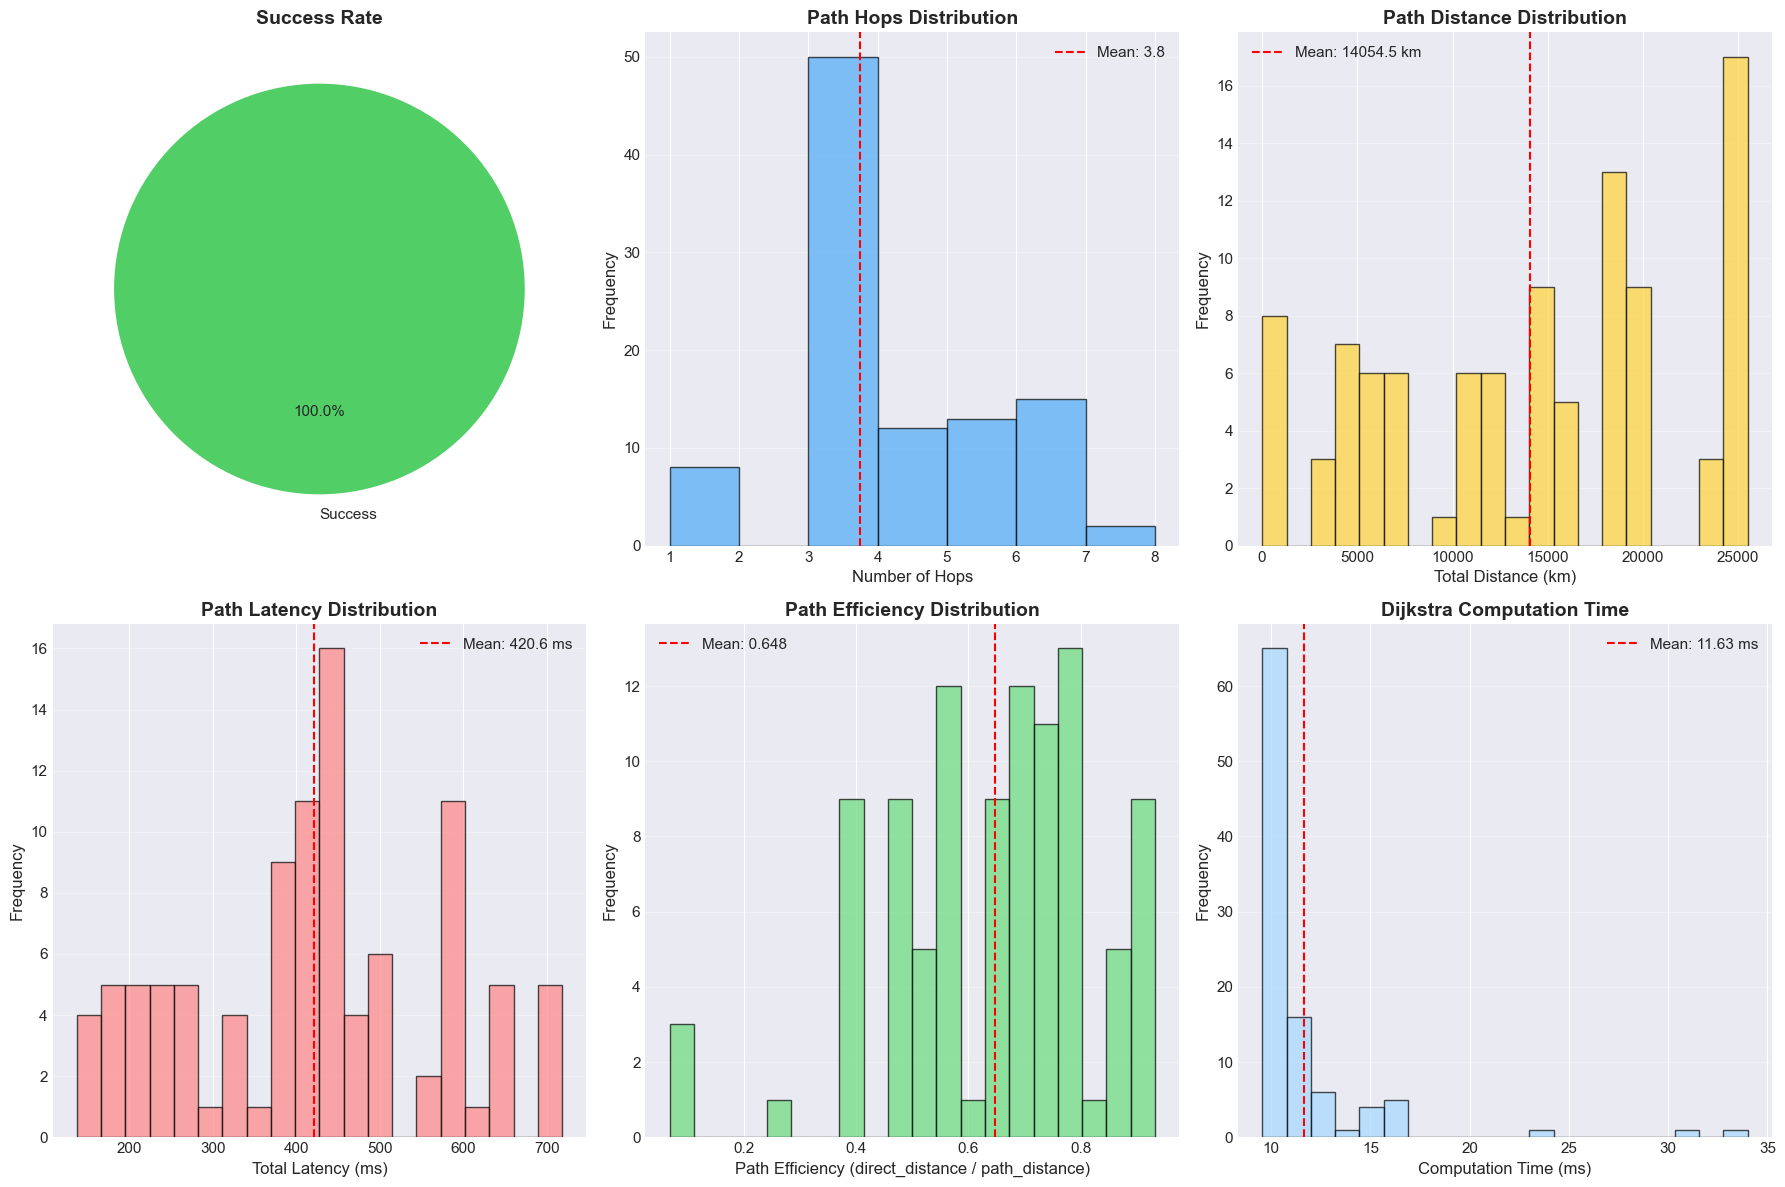


✓ Visualizations complete


In [6]:
# Visualize test results
if test_results is not None and len(test_results) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    successful_df = test_results[test_results['success'] == True]
    
    # 1. Success Rate
    ax1 = axes[0, 0]
    success_counts = test_results['success'].value_counts()
    # Ensure we have both True and False counts
    success_count = success_counts.get(True, 0)
    failure_count = success_counts.get(False, 0)
    
    if success_count + failure_count > 0:
        values = [failure_count, success_count]
        labels = ['Failed', 'Success']
        colors_list = ['#ff6b6b', '#51cf66']
        # Filter out zero values
        filtered_data = [(v, l, c) for v, l, c in zip(values, labels, colors_list) if v > 0]
        if filtered_data:
            values_filtered, labels_filtered, colors_filtered = zip(*filtered_data)
            ax1.pie(values_filtered, labels=labels_filtered, autopct='%1.1f%%', 
                    colors=colors_filtered, startangle=90)
        else:
            ax1.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax1.transAxes)
    else:
        ax1.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Success Rate', fontsize=14, fontweight='bold')
    
    # 2. Hops Distribution
    ax2 = axes[0, 1]
    if len(successful_df) > 0:
        ax2.hist(successful_df['hops'], bins=range(1, int(successful_df['hops'].max())+2), 
                edgecolor='black', alpha=0.7, color='#4dabf7')
        ax2.axvline(x=successful_df['hops'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["hops"].mean():.1f}')
        ax2.set_xlabel('Number of Hops', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title('Path Hops Distribution', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Distance Distribution
    ax3 = axes[0, 2]
    if len(successful_df) > 0:
        ax3.hist(successful_df['total_distance_km'], bins=20, edgecolor='black', 
                alpha=0.7, color='#ffd43b')
        ax3.axvline(x=successful_df['total_distance_km'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["total_distance_km"].mean():.1f} km')
        ax3.set_xlabel('Total Distance (km)', fontsize=12)
        ax3.set_ylabel('Frequency', fontsize=12)
        ax3.set_title('Path Distance Distribution', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Latency Distribution
    ax4 = axes[1, 0]
    if len(successful_df) > 0:
        ax4.hist(successful_df['total_latency_ms'], bins=20, edgecolor='black', 
                alpha=0.7, color='#ff8787')
        ax4.axvline(x=successful_df['total_latency_ms'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["total_latency_ms"].mean():.1f} ms')
        ax4.set_xlabel('Total Latency (ms)', fontsize=12)
        ax4.set_ylabel('Frequency', fontsize=12)
        ax4.set_title('Path Latency Distribution', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Efficiency Distribution
    ax5 = axes[1, 1]
    if len(successful_df) > 0:
        ax5.hist(successful_df['efficiency'], bins=20, edgecolor='black', 
                alpha=0.7, color='#69db7c')
        ax5.axvline(x=successful_df['efficiency'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["efficiency"].mean():.3f}')
        ax5.set_xlabel('Path Efficiency (direct_distance / path_distance)', fontsize=12)
        ax5.set_ylabel('Frequency', fontsize=12)
        ax5.set_title('Path Efficiency Distribution', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Computation Time
    ax6 = axes[1, 2]
    if len(successful_df) > 0:
        ax6.hist(successful_df['computation_time_ms'], bins=20, edgecolor='black', 
                alpha=0.7, color='#a5d8ff')
        ax6.axvline(x=successful_df['computation_time_ms'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["computation_time_ms"].mean():.2f} ms')
        ax6.set_xlabel('Computation Time (ms)', fontsize=12)
        ax6.set_ylabel('Frequency', fontsize=12)
        ax6.set_title('Dijkstra Computation Time', fontsize=14, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualizations complete")


## 6. Detailed Analysis


In [7]:
# Detailed analysis
if test_results is not None and len(test_results) > 0:
    successful_df = test_results[test_results['success'] == True]
    failed_df = test_results[test_results['success'] == False]
    
    print("=" * 60)
    print("DIJKSTRA ROUTING ANALYSIS")
    print("=" * 60)
    print(f"\n📊 Overall Statistics:")
    print(f"  Total tests: {len(test_results)}")
    print(f"  Successful: {len(successful_df)} ({len(successful_df)/len(test_results)*100:.1f}%)")
    print(f"  Failed: {len(failed_df)} ({len(failed_df)/len(test_results)*100:.1f}%)")
    
    if len(successful_df) > 0:
        print(f"\n✅ Successful Path Metrics:")
        print(f"  Mean hops: {successful_df['hops'].mean():.2f} (std: {successful_df['hops'].std():.2f})")
        print(f"  Min hops: {successful_df['hops'].min()}")
        print(f"  Max hops: {successful_df['hops'].max()}")
        print(f"\n  Mean distance: {successful_df['total_distance_km'].mean():.2f} km (std: {successful_df['total_distance_km'].std():.2f} km)")
        print(f"  Min distance: {successful_df['total_distance_km'].min():.2f} km")
        print(f"  Max distance: {successful_df['total_distance_km'].max():.2f} km")
        print(f"\n  Mean latency: {successful_df['total_latency_ms'].mean():.2f} ms (std: {successful_df['total_latency_ms'].std():.2f} ms)")
        print(f"  Min latency: {successful_df['total_latency_ms'].min():.2f} ms")
        print(f"  Max latency: {successful_df['total_latency_ms'].max():.2f} ms")
        print(f"\n  Mean efficiency: {successful_df['efficiency'].mean():.3f} (std: {successful_df['efficiency'].std():.3f})")
        print(f"  Mean computation time: {successful_df['computation_time_ms'].mean():.2f} ms")
    
    if len(failed_df) > 0:
        print(f"\n❌ Failure Analysis:")
        error_counts = failed_df['error'].value_counts()
        for error, count in error_counts.items():
            print(f"  {error}: {count} ({count/len(failed_df)*100:.1f}%)")
    
    # Distance vs Hops analysis
    if len(successful_df) > 0:
        print(f"\n📈 Distance vs Hops Correlation:")
        correlation = successful_df['terminal_distance_km'].corr(successful_df['hops'])
        print(f"  Correlation: {correlation:.3f}")
        
        # Group by distance ranges
        successful_df['distance_range'] = pd.cut(
            successful_df['terminal_distance_km'],
            bins=[0, 2000, 5000, 10000, float('inf')],
            labels=['Near (<2k km)', 'Medium (2-5k km)', 'Far (5-10k km)', 'Very Far (>10k km)']
        )
        
        print(f"\n📊 Performance by Distance Range:")
        for dist_range in successful_df['distance_range'].cat.categories:
            range_df = successful_df[successful_df['distance_range'] == dist_range]
            if len(range_df) > 0:
                print(f"  {dist_range}:")
                print(f"    Count: {len(range_df)}")
                print(f"    Mean hops: {range_df['hops'].mean():.2f}")
                print(f"    Mean distance: {range_df['total_distance_km'].mean():.2f} km")
                print(f"    Mean latency: {range_df['total_latency_ms'].mean():.2f} ms")
    
    print("\n" + "=" * 60)


DIJKSTRA ROUTING ANALYSIS

📊 Overall Statistics:
  Total tests: 100
  Successful: 100 (100.0%)
  Failed: 0 (0.0%)

✅ Successful Path Metrics:
  Mean hops: 3.75 (std: 1.45)
  Min hops: 1
  Max hops: 7

  Mean distance: 14054.51 km (std: 7953.76 km)
  Min distance: 14.41 km
  Max distance: 25496.06 km

  Mean latency: 420.59 ms (std: 153.36 ms)
  Min latency: 136.84 ms
  Max latency: 718.52 ms

  Mean efficiency: 0.648 (std: 0.184)
  Mean computation time: 11.63 ms

📈 Distance vs Hops Correlation:
  Correlation: 0.269

📊 Performance by Distance Range:
  Near (<2k km):
    Count: 13
    Mean hops: 1.77
    Mean distance: 1381.61 km
    Mean latency: 245.49 ms
  Medium (2-5k km):
    Count: 5
    Mean hops: 3.00
    Mean distance: 4781.56 km
    Mean latency: 270.47 ms
  Far (5-10k km):
    Count: 51
    Mean hops: 4.22
    Mean distance: 13407.67 km
    Mean latency: 451.06 ms
  Very Far (>10k km):
    Count: 31
    Mean hops: 3.94
    Mean distance: 21928.75 km
    Mean latency: 468.11 m

## 7. Distance vs Performance Analysis


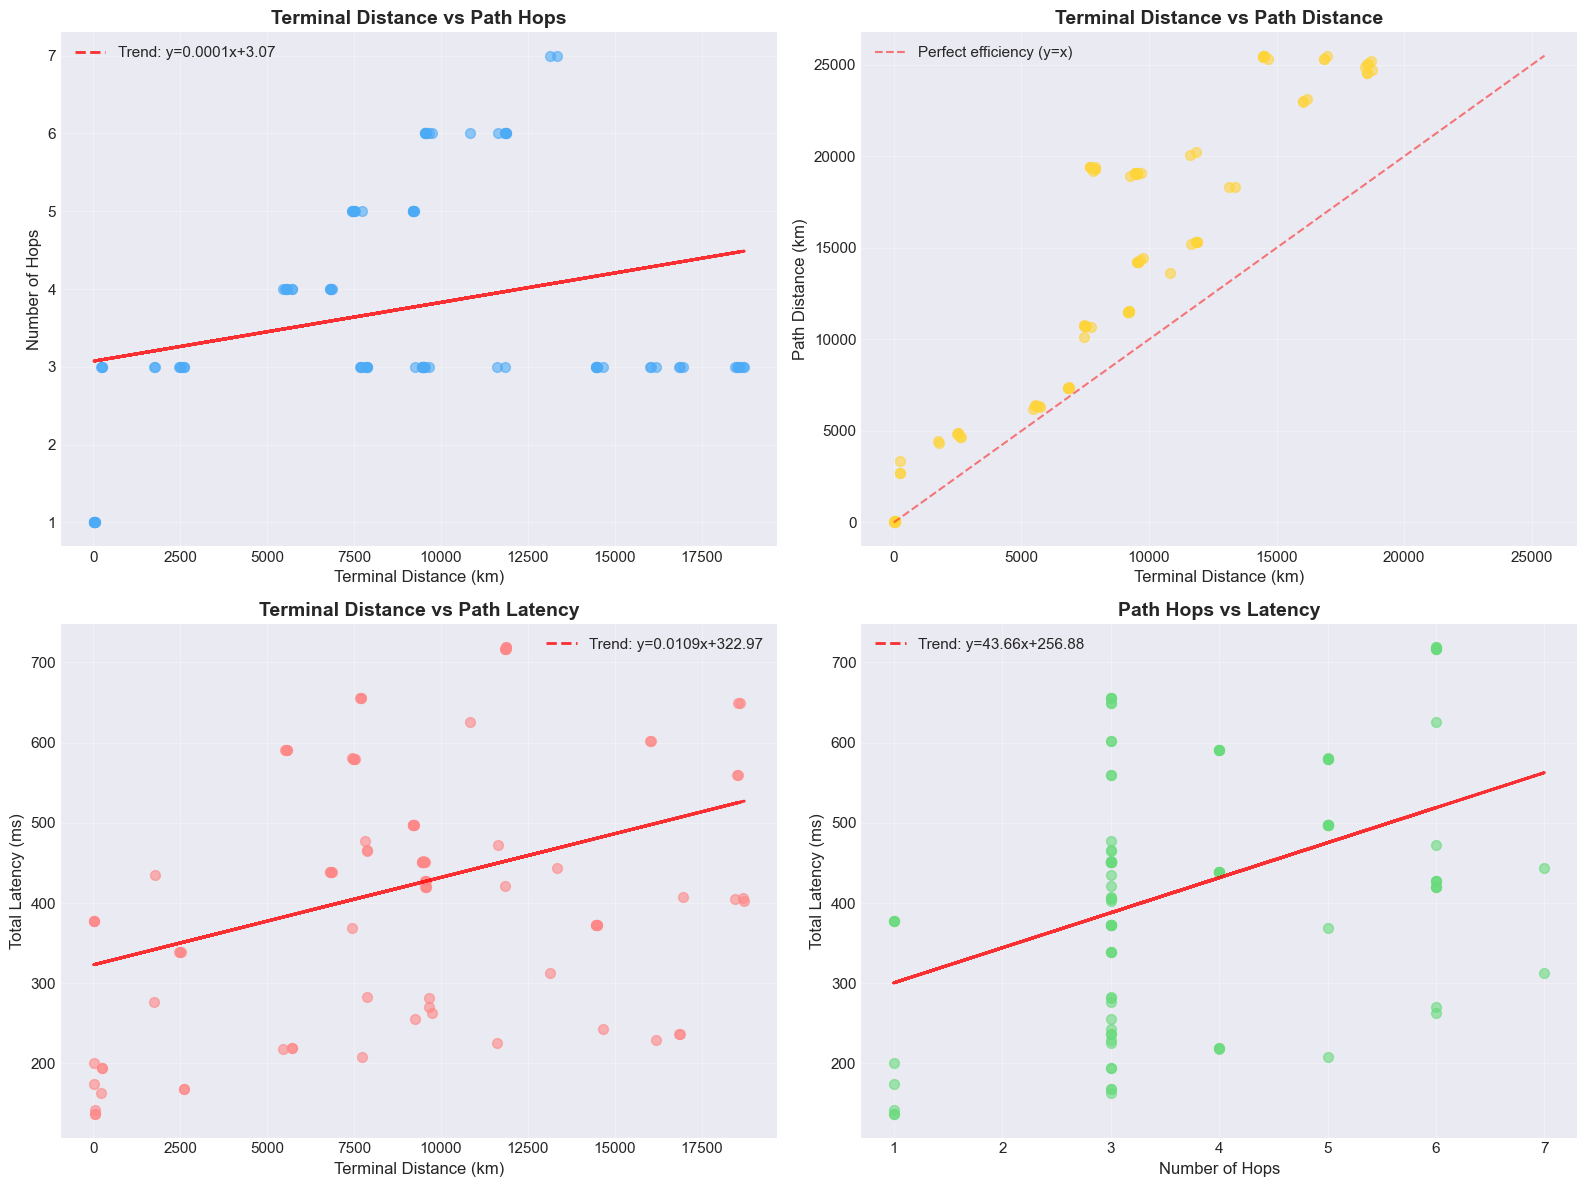


✓ Distance vs Performance analysis complete


In [8]:
# Analyze relationship between terminal distance and path metrics
if test_results is not None and len(test_results) > 0:
    successful_df = test_results[test_results['success'] == True]
    
    if len(successful_df) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Distance vs Hops
        ax1 = axes[0, 0]
        ax1.scatter(successful_df['terminal_distance_km'], successful_df['hops'], 
                   alpha=0.6, s=50, color='#4dabf7')
        z = np.polyfit(successful_df['terminal_distance_km'], successful_df['hops'], 1)
        p = np.poly1d(z)
        ax1.plot(successful_df['terminal_distance_km'], p(successful_df['terminal_distance_km']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
        ax1.set_xlabel('Terminal Distance (km)', fontsize=12)
        ax1.set_ylabel('Number of Hops', fontsize=12)
        ax1.set_title('Terminal Distance vs Path Hops', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Distance vs Path Distance
        ax2 = axes[0, 1]
        ax2.scatter(successful_df['terminal_distance_km'], successful_df['total_distance_km'], 
                   alpha=0.6, s=50, color='#ffd43b')
        # Add diagonal line (perfect efficiency)
        max_dist = max(successful_df['terminal_distance_km'].max(), successful_df['total_distance_km'].max())
        ax2.plot([0, max_dist], [0, max_dist], 'r--', alpha=0.5, label='Perfect efficiency (y=x)')
        ax2.set_xlabel('Terminal Distance (km)', fontsize=12)
        ax2.set_ylabel('Path Distance (km)', fontsize=12)
        ax2.set_title('Terminal Distance vs Path Distance', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Distance vs Latency
        ax3 = axes[1, 0]
        ax3.scatter(successful_df['terminal_distance_km'], successful_df['total_latency_ms'], 
                   alpha=0.6, s=50, color='#ff8787')
        z = np.polyfit(successful_df['terminal_distance_km'], successful_df['total_latency_ms'], 1)
        p = np.poly1d(z)
        ax3.plot(successful_df['terminal_distance_km'], p(successful_df['terminal_distance_km']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
        ax3.set_xlabel('Terminal Distance (km)', fontsize=12)
        ax3.set_ylabel('Total Latency (ms)', fontsize=12)
        ax3.set_title('Terminal Distance vs Path Latency', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Hops vs Latency
        ax4 = axes[1, 1]
        ax4.scatter(successful_df['hops'], successful_df['total_latency_ms'], 
                   alpha=0.6, s=50, color='#69db7c')
        z = np.polyfit(successful_df['hops'], successful_df['total_latency_ms'], 1)
        p = np.poly1d(z)
        ax4.plot(successful_df['hops'], p(successful_df['hops']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
        ax4.set_xlabel('Number of Hops', fontsize=12)
        ax4.set_ylabel('Total Latency (ms)', fontsize=12)
        ax4.set_title('Path Hops vs Latency', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Distance vs Performance analysis complete")


## 8. Summary Statistics Table


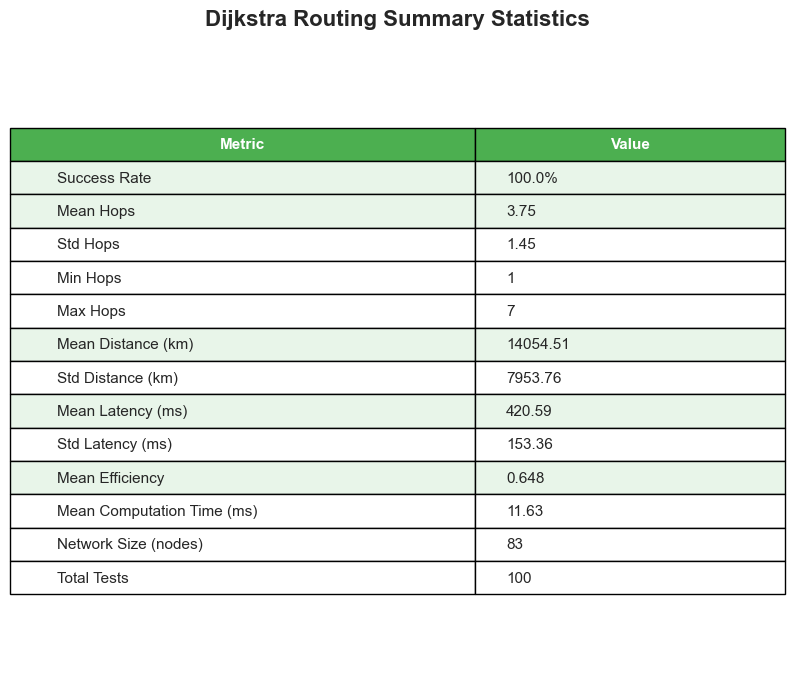


✓ Summary statistics displayed


In [9]:
# Create summary statistics table
if test_results is not None and len(test_results) > 0:
    successful_df = test_results[test_results['success'] == True]
    
    if len(successful_df) > 0:
        summary_stats = {
            'Metric': [
                'Success Rate',
                'Mean Hops',
                'Std Hops',
                'Min Hops',
                'Max Hops',
                'Mean Distance (km)',
                'Std Distance (km)',
                'Mean Latency (ms)',
                'Std Latency (ms)',
                'Mean Efficiency',
                'Mean Computation Time (ms)',
                'Network Size (nodes)',
                'Total Tests'
            ],
            'Value': [
                f"{len(successful_df)/len(test_results)*100:.1f}%",
                f"{successful_df['hops'].mean():.2f}",
                f"{successful_df['hops'].std():.2f}",
                f"{successful_df['hops'].min()}",
                f"{successful_df['hops'].max()}",
                f"{successful_df['total_distance_km'].mean():.2f}",
                f"{successful_df['total_distance_km'].std():.2f}",
                f"{successful_df['total_latency_ms'].mean():.2f}",
                f"{successful_df['total_latency_ms'].std():.2f}",
                f"{successful_df['efficiency'].mean():.3f}",
                f"{successful_df['computation_time_ms'].mean():.2f}",
                f"{operational_nodes}",
                f"{len(test_results)}"
            ]
        }
        
        summary_df = pd.DataFrame(summary_stats)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.axis('off')
        table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                        cellLoc='left', loc='center', colWidths=[0.6, 0.4])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)
        ax.set_title('Dijkstra Routing Summary Statistics', fontsize=16, fontweight='bold', pad=20)
        
        # Style table
        for i in range(len(summary_df.columns)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Highlight key metrics
        key_rows = [0, 1, 5, 7, 9]  # Success rate, hops, distance, latency, efficiency
        for row_idx in key_rows:
            if row_idx < len(summary_df):
                for col_idx in range(len(summary_df.columns)):
                    table[(row_idx + 1, col_idx)].set_facecolor('#e8f5e9')
        
        plt.show()
        
        print(f"\n✓ Summary statistics displayed")


## 9. Test with Different Resource Awareness Settings


INFO:__main__:============================================================
INFO:__main__:Testing Dijkstra Routing (50 test cases)
INFO:__main__:============================================================
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-071 for terminal TERM-1766343334157-0000 (distance: 31.8km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-063 for terminal TERM-1766343365352-0000 (distance: 15.2km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 4 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 4 hops, 19239.2km (shortest distance), 477.67ms latency
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-075 for terminal TERM-0012 (distance: 8.7km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-059 for terminal TERM-0008 (distance: 12.4km, N

COMPARING RESOURCE-AWARE vs NON-RESOURCE-AWARE ROUTING


INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 4 hops, 19405.3km (shortest distance), 655.90ms latency
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-079 for terminal TERM-1766343303835-0000 (distance: 22.3km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-071 for terminal TERM-1766343331271-0000 (distance: 57.2km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 5 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 4 hops, 25455.5km (shortest distance), 373.07ms latency
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-067 for terminal TERM-1766343342548-0000 (distance: 21.9km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-063 for terminal TERM-1766343364489-0000 (distance: 17.6km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dro

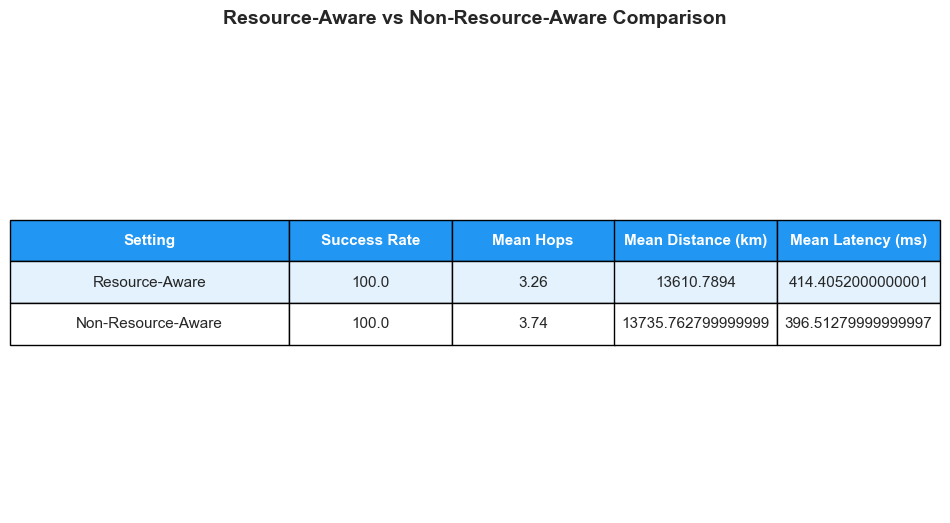


✓ Comparison complete


In [10]:
# Compare resource-aware vs non-resource-aware routing
print("=" * 60)
print("COMPARING RESOURCE-AWARE vs NON-RESOURCE-AWARE ROUTING")
print("=" * 60)

# Test with resource-aware
results_aware = test_dijkstra_routing(
    nodes=nodes,
    terminals=terminals,
    num_tests=50,
    resource_aware=True
)

# Test without resource-aware
results_non_aware = test_dijkstra_routing(
    nodes=nodes,
    terminals=terminals,
    num_tests=50,
    resource_aware=False
)

if results_aware is not None and results_non_aware is not None:
    aware_successful = results_aware[results_aware['success'] == True]
    non_aware_successful = results_non_aware[results_non_aware['success'] == True]
    
    comparison = {
        'Setting': ['Resource-Aware', 'Non-Resource-Aware'],
        'Success Rate': [
            len(aware_successful)/len(results_aware)*100,
            len(non_aware_successful)/len(results_non_aware)*100
        ],
        'Mean Hops': [
            aware_successful['hops'].mean() if len(aware_successful) > 0 else 0,
            non_aware_successful['hops'].mean() if len(non_aware_successful) > 0 else 0
        ],
        'Mean Distance (km)': [
            aware_successful['total_distance_km'].mean() if len(aware_successful) > 0 else 0,
            non_aware_successful['total_distance_km'].mean() if len(non_aware_successful) > 0 else 0
        ],
        'Mean Latency (ms)': [
            aware_successful['total_latency_ms'].mean() if len(aware_successful) > 0 else 0,
            non_aware_successful['total_latency_ms'].mean() if len(non_aware_successful) > 0 else 0
        ]
    }
    
    comparison_df = pd.DataFrame(comparison)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                    cellLoc='center', loc='center', colWidths=[0.3, 0.175, 0.175, 0.175, 0.175])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    ax.set_title('Resource-Aware vs Non-Resource-Aware Comparison', fontsize=14, fontweight='bold', pad=20)
    
    # Style table
    for i in range(len(comparison_df.columns)):
        table[(0, i)].set_facecolor('#2196F3')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight resource-aware row
    for col_idx in range(len(comparison_df.columns)):
        table[(1, col_idx)].set_facecolor('#e3f2fd')
    
    plt.show()
    
    print(f"\n✓ Comparison complete")


## 10. Final Summary


In [11]:
# Generate final summary
print("=" * 60)
print("DIJKSTRA ROUTING TEST SUMMARY")
print("=" * 60)
print(f"\nTest Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if test_results is not None:
    successful_df = test_results[test_results['success'] == True]
    
    print(f"\n📊 Network Configuration:")
    print(f"  Operational nodes: {operational_nodes}")
    print(f"  Total terminals: {len(terminals)}")
    
    print(f"\n✅ Routing Performance:")
    print(f"  Success rate: {len(successful_df)/len(test_results)*100:.1f}%")
    if len(successful_df) > 0:
        print(f"  Mean hops: {successful_df['hops'].mean():.2f}")
        print(f"  Mean distance: {successful_df['total_distance_km'].mean():.2f} km")
        print(f"  Mean latency: {successful_df['total_latency_ms'].mean():.2f} ms")
        print(f"  Mean efficiency: {successful_df['efficiency'].mean():.3f}")
        print(f"  Mean computation time: {successful_df['computation_time_ms'].mean():.2f} ms")
    
    print(f"\n💡 Key Findings:")
    if len(successful_df) > 0:
        if successful_df['efficiency'].mean() > 0.8:
            print("  ✓ Path efficiency is good (>0.8)")
        else:
            print("  ⚠️ Path efficiency could be improved (<0.8)")
        
        if successful_df['hops'].mean() < 5:
            print("  ✓ Average path length is reasonable (<5 hops)")
        else:
            print("  ⚠️ Average path length is high (>=5 hops)")
        
        if len(successful_df)/len(test_results) > 0.9:
            print("  ✓ Success rate is excellent (>90%)")
        elif len(successful_df)/len(test_results) > 0.7:
            print("  ✓ Success rate is good (70-90%)")
        else:
            print("  ⚠️ Success rate is low (<70%) - may need network improvements")
    
    print(f"\n📈 Recommendations:")
    if len(successful_df) == 0:
        print("  ⚠️ No successful paths found. Check:")
        print("     - Network connectivity")
        print("     - Node operational status")
        print("     - Terminal positions")
    elif len(successful_df)/len(test_results) < 0.7:
        print("  ⚠️ Low success rate. Consider:")
        print("     - Adding more nodes for better coverage")
        print("     - Adjusting resource thresholds")
        print("     - Checking network topology")
    else:
        print("  ✓ Dijkstra routing is performing well with current network")
        print("     - Can be used as baseline for RL comparison")
        print("     - Resource-aware routing helps avoid congested nodes")

print("\n" + "=" * 60)
print("✅ Test Complete")
print("=" * 60)


DIJKSTRA ROUTING TEST SUMMARY

Test Date: 2025-12-22 17:43:53

📊 Network Configuration:
  Operational nodes: 83
  Total terminals: 92

✅ Routing Performance:
  Success rate: 100.0%
  Mean hops: 3.75
  Mean distance: 14054.51 km
  Mean latency: 420.59 ms
  Mean efficiency: 0.648
  Mean computation time: 11.63 ms

💡 Key Findings:
  ⚠️ Path efficiency could be improved (<0.8)
  ✓ Average path length is reasonable (<5 hops)
  ✓ Success rate is excellent (>90%)

📈 Recommendations:
  ✓ Dijkstra routing is performing well with current network
     - Can be used as baseline for RL comparison
     - Resource-aware routing helps avoid congested nodes

✅ Test Complete
